In [1]:
from utils.getter import *
import torchvision

In [2]:
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
loss_func = losses.TripletMarginLoss(distance = CosineSimilarity(), 
				     reducer = ThresholdReducer(high=0.3), 
			 	     embedding_regularizer = LpRegularizer())

In [ ]:
device = torch.device('cuda')

In [3]:
transforms = Compose([
 #   Resize((300,300)),
    ToTensor(),
    Normalize(),
])

In [4]:
img_path = "datasets/datasets/Velastin/images"
anno_path = {
    "train": "datasets/datasets/Velastin/annotations/velastin_train.json",
    "val": "datasets/datasets/Velastin/annotations/velastin_val.json"}

trainset = ObjectDetectionDataset(img_dir=img_path, ann_path = anno_path['train'],transforms= transforms)
valset = ObjectDetectionDataset(img_dir=img_path, ann_path = anno_path['val'],transforms= transforms)
NUM_CLASSES = len(trainset.classes)
print(trainset)
print(valset)

Custom Dataset for Object Detection
-------------------------------
Number of samples: 8000
Number of classes: 3

Custom Dataset for Object Detection
-------------------------------
Number of samples: 2000
Number of classes: 3



In [30]:
print(trainset.annos['annotations'][-1])

{'area': 0, 'bbox': [240, 105, 15, 25], 'category_id': 1, 'id': 41503, 'ignore': 0, 'image_id': '009999', 'iscrowd': 0, 'obj_id': 317, 'segmentation': []}


In [ ]:
trainset.visualize_item(0)

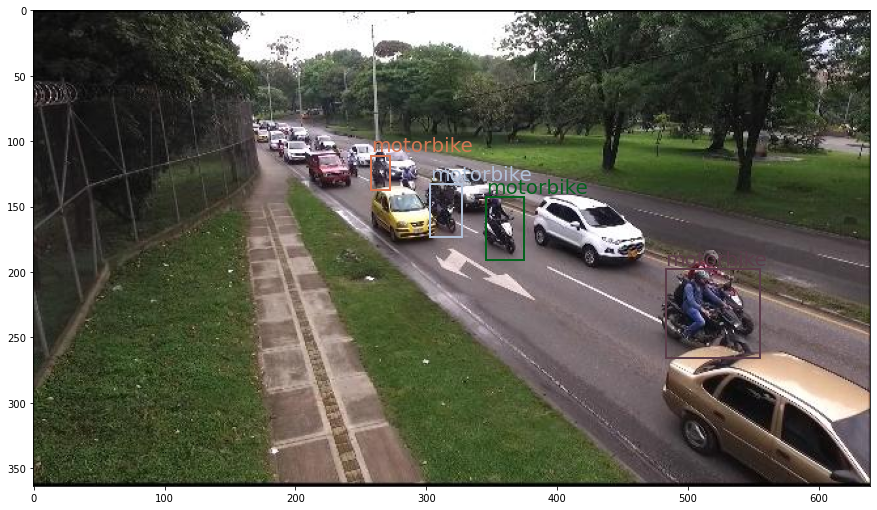

In [5]:
item = trainset[7]
img_tensor = item['img']
img = torchvision.transforms.transforms.ToPILImage(mode='RGB')(img_tensor)
boxes = item['box'].numpy()
labels = item['label'].numpy()
trainset.visualize(img,boxes, labels)

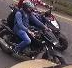

In [6]:
import numpy as np
box = [int(i) for i in boxes[0]]
x,y,w,h = box
roi = img_tensor[:, y:y+h, x:x+w]
img_crop = torchvision.transforms.transforms.ToPILImage(mode='RGB')(roi)
display(img_crop)